<a href="https://colab.research.google.com/github/hey-simone/flowers-classifier/blob/master/Keras_Flowers_Classifier-V1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras/TensorFlow Flowers Classifier

## Approach

In this notebook, we have a look at classifying flowers with **convolutional neural networks** in **Keras** using the **TensorFlow** backend.

### Dataset
The dataset used can be found on Kaggle here: https://www.kaggle.com/alxmamaev/flowers-recognition. It contains 4242 images of 5 different categories of flowers which were scraped from various sources on the web. The categories are **daisy, dandelion, rose, sunflower, and tulip**. These photos need to be preprocessed as they are of varying dimensions and will not fit into the convnet as is. Some of the unprocessed images from each category are shown below.
        
![Sample Images](https://raw.githubusercontent.com/hey-simone/flowers-classifier/master/assets/Image-Samples.png)


I chose this dataset because though it is small it has similar features to some of the training classes of ImageNet. This means that they can be used to do **transfer learning** and **fine-tuning** effectively with pre-trained models from `keras.applications`. The ImageNet dataset actually has more photos for the plant category than the category for the cats and dogs. This is significant because a precedent I am using on cats and dogs from Francois Chollet's *Deep Learning with Python* performed very well (97% accuracy with the validation set) using fine-tuning with a **VGG16** pre-trained model. Thus it seemed like a sensible starting point.


Thus, we follow a similar approach here which is detailed further in the rest of the notebook. This dataset is slightly more challenging than ImageNet itself as the photos are taken in more natural contexts in a similar way to the precedent mentioned. Thus it is expected to perform similarly to the precedent with fine-tuning (Null Hypothesis).

### Overview
We look at preparing, importing and exploring the data with some light preprocessing. Then visualize the data in the notebook with a helper function after preprocessing. 

Next, we move on to some more preprocessing with normalization and data augmentation and the models. This section accounts for the bulk of the notebook. We create a baseline model with a basic convnet to compare the performance of the other models. This model overfits, so we add data augmentation and dropout. Then we use VGG16 and DenseNet161 in various configurations for feature extraction and fine-tuning. Then we evaluate the best model on the test set to verify performance.

Finally, we have the conclusion, possible directions for future work and references.

### Outcomes
***The best model was a fine-tuned DenseNet161 model with 91% test set accuracy and 90% validation set accuracy.*** Thus the null was rejected as the dataset performed worse than the precedent. This is likely because the classification task here is more granular than the precedential task on the generic classes of cats and dogs so the problem of classifying specific flowers is a bit more challenging.


## Preparing, Importing, and Exploring the Data

To prepare the data I downloaded it from Kaggle. The data is not split into train, validation and test sets so the first challenge is to split the data. We cannot test performance on the training data because it was already seen by the model so this does not give a good indication of how the model would perform on unseen data. Thus we use a test set. However, we can fit to the test set while building the model, so we add in the validation set to check performance when training, and then use the test set afterwards to check performance on completely new data.

This can be done using the os module but since it is a small dataset I chose to do it manually by creating the directory structure myself which looks as follows:

```
flowers-kaggle

- test
-- daisy
-- dandelion
-- rose
-- sunflower
-- tulip

- train
-- daisy
-- dandelion
-- rose
-- sunflower
-- tulip

- valid
-- daisy
-- dandelion
-- rose
-- sunflower
-- tulip

```



Each subfolder has folders for each class. Since the dataset is relatively small I allocated 60% of each class for the training set, 20% of each class for the validation set and 20% of each class for the test set.

Since I'm using Colab, I zipped up the main folder and uploaded it into the runtime then extracted it as shown below for use.

Next, I use the **ImageDataGenerator** to explore the data and create a baseline model for comparison. The images are later rescaled between 0 and 1 because neural networks prefer to work with this scale. The scaling is not yet done so the preprocessed images can be visualized in the notebook. I use a batch size of 32 since it is common to use a power of 2 and there are enough images for this to be feasible.



In [0]:
# upload to the main folder and it will open in the content folder
!unzip -qq /flowers-kaggle-valid.zip

In [0]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
train_path = 'flowers-kaggle/train'
valid_path = 'flowers-kaggle/valid'
test_path = 'flowers-kaggle/test'

### ImageDataGenerator

In [0]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                                   batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

Found 2591 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 866 images belonging to 5 classes.


### Exploring the Generated Data

It is helpful to see the classes that are automatically assigned by Keras to the data. Since the classes are categorical, numerical values are needed to train the model.

In [0]:
# classes assigned by keras
test_batches.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

To view one batch of training data we can get a batch and look at the shape. There are 32 images, of dimensions 224 x 224 and 3 channels as expected.

In [0]:
imgs, labels = next(train_batches)

In [0]:
imgs.shape

(32, 224, 224, 3)

In [0]:
imgs[0]

array([[[ 16.,  24.,   0.],
        [ 17.,  25.,   2.],
        [ 17.,  25.,   2.],
        ...,
        [ 47.,  41.,  41.],
        [ 47.,  41.,  43.],
        [ 47.,  41.,  43.]],

       [[ 15.,  23.,   0.],
        [ 15.,  23.,   0.],
        [ 15.,  23.,   0.],
        ...,
        [ 52.,  46.,  46.],
        [ 52.,  46.,  48.],
        [ 52.,  46.,  48.]],

       [[ 15.,  23.,   0.],
        [ 15.,  23.,   0.],
        [ 15.,  23.,   0.],
        ...,
        [ 52.,  46.,  46.],
        [ 52.,  46.,  48.],
        [ 52.,  46.,  48.]],

       ...,

       [[119., 114., 120.],
        [120., 115., 121.],
        [124., 119., 125.],
        ...,
        [123., 122., 127.],
        [120., 119., 124.],
        [118., 117., 122.]],

       [[119., 114., 120.],
        [120., 115., 121.],
        [124., 119., 125.],
        ...,
        [123., 122., 127.],
        [120., 119., 124.],
        [118., 117., 122.]],

       [[120., 115., 121.],
        [120., 115., 121.],
        [122., 1

The labels for each image have been **one-hot encoded**. Since we have 32 images we have 32 labels and each label has 5 elements corresponding to each possible category.

In [0]:
labels.shape

(32, 5)

In [0]:
labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

## Visualize some of the Data

Here is a convenience function from https://github.com/smileservices/keras_utils/blob/master/utils.py which can plot the preprocessed images and the assigned classes.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.preprocessing.image import ImageDataGenerator

# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


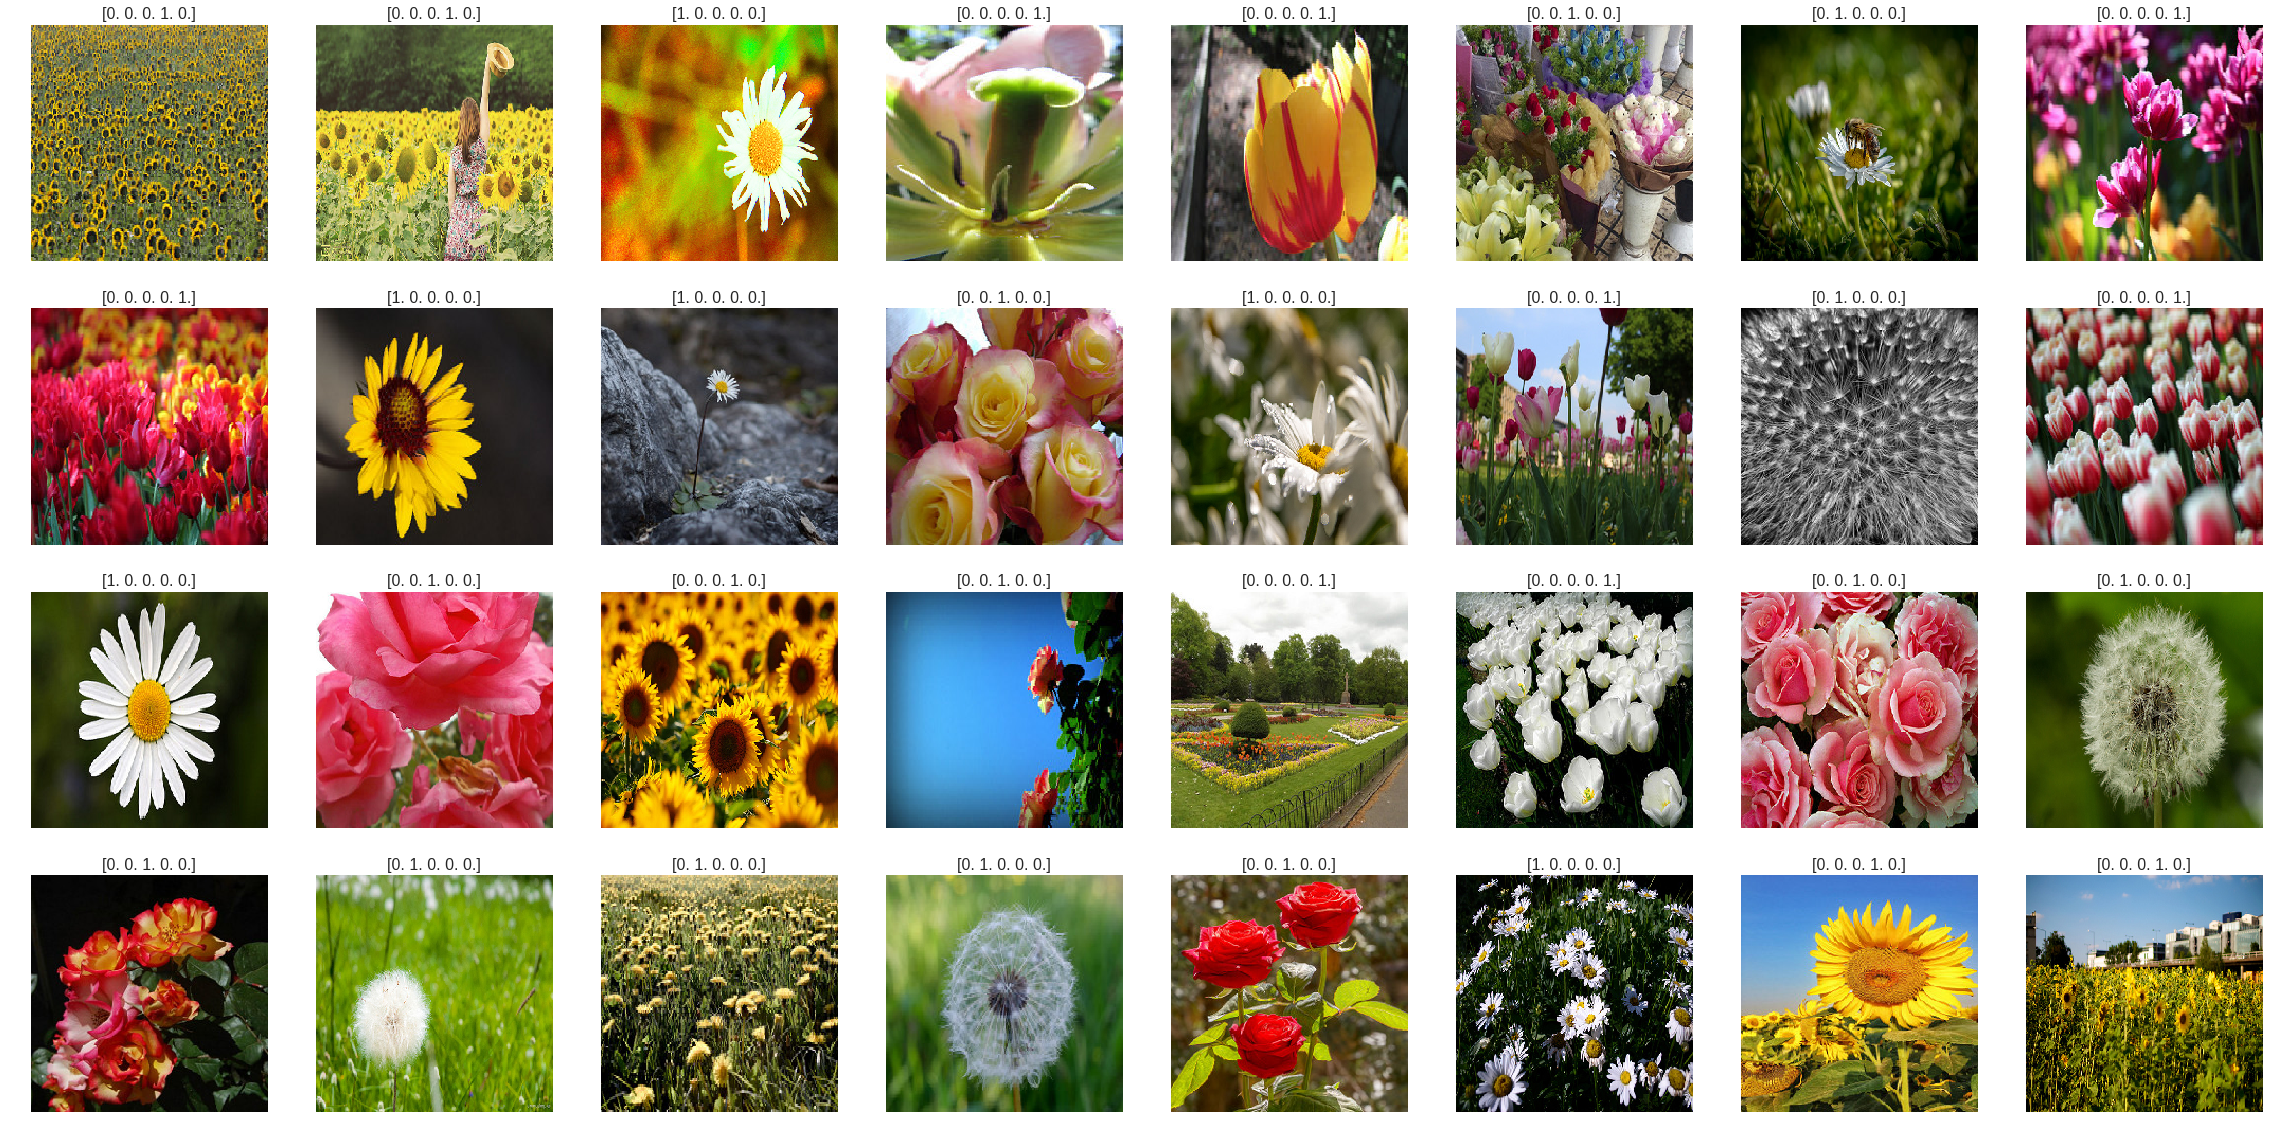

In [0]:
#['daisy','dandelion', 'rose', 'sunflower', 'tulip']
plots(imgs, figsize=(40,20), rows = 4, titles=labels)

## Modelling
### Imports


In [0]:
# import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Dense, Flatten, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### Baseline Model

For the baseline model we use the same data generator code from above and normalize the data since this works better for neural nets. Afterwards we will add in data augmentation and dropout to to reduce overfitting.


In [0]:
# generates batches of normalized data.

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                                   batch_size=32)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

Found 2591 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 866 images belonging to 5 classes.


We use **convolutional layers** because they are spatially invariant and great for images. This means that no matter where an element appears in an image it can be detected. This is because conv layers use filters which slide over the image/volumes to produce activation maps.

![alt text](https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif)

[The convolution operation](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)


The **max pooling layers** generally come after the convolutional layers. They shrink the size of the volume by taking the max value within the filter and hence reduce computation costs as we move through the network.

![Max Pooling](https://cdn-images-1.medium.com/max/1600/1*Feiexqhmvh9xMGVVJweXhg.gif)

[Max Pooling](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)


**ReLU's** or Rectified Linear Units are used as the activation function because they help reduce **vanishing gradients** which are an issue with **sigmoid** and **TanH activation** layers. Vanishing gradients are a problem because they reduce the likelihood that a signal will propagate to the input layer and adjust those weights. Hence the earlier layers will not learn. 

![alt text](https://cdn-images-1.medium.com/max/1600/1*rIiBaH5IMVPaE5BM-n7VZw.png)

[Activation Functions](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)


The last layer has a softmax activation with 5 units to account for the 5 classes of the dataset. We will get a probability for each of the classes.

I like the Adam optimizer because it adjusts the learning rate separately per layer and can be used with weight decay so that when we get close to convergence the learning can be reduced so we can thus get better results. Categorical crossentropy is chosen since this is a multiclass classification problem.

*Based on model in Listing 5.5 from Chollet's Deep Learning.*

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [0]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

We use the `fit_generator` here because we are getting the data from an `ImageDataGenerator`. These correspond to generators in python and can produce batches into infinity. Running for 30 epochs we see that the best validation accuracy is about **0.6440**, which is not that great compared to the 97% from our comparison model. Looking at our validation curves we start overfitting at about 5-10 epochs. We can tell this because the validation loss starts to increase and diverges from the test loss which continues to decrease. We still have some work to do!

In [0]:
history = model.fit_generator(
      train_batches,
      steps_per_epoch=81,
      epochs=30,
      validation_data=valid_batches,
      validation_steps=40,
      verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 21s - loss: 1.4522 - acc: 0.3524 - val_loss: 1.2218 - val_acc: 0.4720
Epoch 2/30
 - 14s - loss: 1.1392 - acc: 0.5191 - val_loss: 1.0934 - val_acc: 0.5480
Epoch 3/30
 - 14s - loss: 1.0429 - acc: 0.5774 - val_loss: 1.0931 - val_acc: 0.5500
Epoch 4/30
 - 14s - loss: 0.9468 - acc: 0.6272 - val_loss: 1.0022 - val_acc: 0.6040
Epoch 5/30
 - 14s - loss: 0.8738 - acc: 0.6738 - val_loss: 1.0620 - val_acc: 0.5787
Epoch 6/30
 - 14s - loss: 0.8209 - acc: 0.6851 - val_loss: 0.9633 - val_acc: 0.6240
Epoch 7/30
 - 14s - loss: 0.7303 - acc: 0.7229 - val_loss: 0.9407 - val_acc: 0.6426
Epoch 8/30
 - 14s - loss: 0.6910 - acc: 0.7399 - val_loss: 0.9911 - val_acc: 0.6288
Epoch 9/30
 - 14s - loss: 0.6116 - acc: 0.7808 - val_loss: 0.9778 - val_acc: 0.6160
Epoch 10/30
 - 14s - loss: 0.5260 - acc: 0.8170 - val_loss: 0.9802 - val_acc: 0.6303
Epoch 11/30
 - 14s - loss: 0.4795 - acc: 0.8279 - val_loss: 1.0332 - val_acc: 0.6336
Epoch 12/30
 - 14s - loss:

In [0]:
model.save('flowers-baseline.h5')

In [0]:
def plot_curves():

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

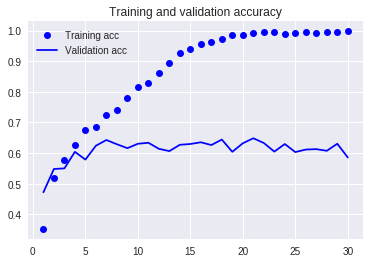

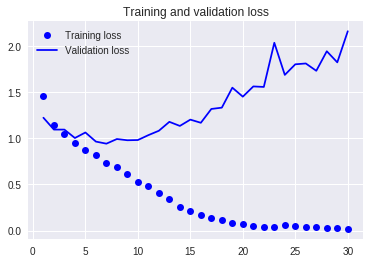

In [0]:
plot_curves()

### Model with Data Augmentation and Dropout

We add in data augmentation here and dropout to compare performance. Data augmentation and dropout reduces the overfitting we saw in our previous model. Parameters for augmentation are put in the arguments for the ImageDataGenerator function. Dropout is added in as a layer in the model. The validation accuracy increases by about .10 in the best case from the last model to 0.7344. Great! We can still do better. Let's try **feature extraction**.

In [0]:
train_batches = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15,
                                   zoom_range=0.1,
                                   channel_shift_range=10.,
                                   horizontal_flip=True, 
                                   fill_mode='nearest').flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                                   batch_size=32)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['daisy','dandelion', 'rose', 'sunflower', 'tulip'], 
                                                        batch_size=32)

Found 2591 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 866 images belonging to 5 classes.


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(rate = 1-0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [0]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
      train_batches,
      steps_per_epoch=81,
      epochs=30,
      validation_data=valid_batches,
      validation_steps=40,
      verbose = 2)

Epoch 1/30
 - 44s - loss: 1.4459 - acc: 0.3551 - val_loss: 1.1968 - val_acc: 0.4744
Epoch 2/30
 - 41s - loss: 1.1699 - acc: 0.5017 - val_loss: 1.1025 - val_acc: 0.5384
Epoch 3/30
 - 41s - loss: 1.1121 - acc: 0.5426 - val_loss: 1.0501 - val_acc: 0.5877
Epoch 4/30
 - 41s - loss: 1.0520 - acc: 0.5782 - val_loss: 1.0200 - val_acc: 0.5824
Epoch 5/30
 - 41s - loss: 1.0006 - acc: 0.6013 - val_loss: 1.1007 - val_acc: 0.5705
Epoch 6/30
 - 41s - loss: 0.9670 - acc: 0.6195 - val_loss: 0.9237 - val_acc: 0.6424
Epoch 7/30
 - 41s - loss: 0.9084 - acc: 0.6411 - val_loss: 0.9061 - val_acc: 0.6656
Epoch 8/30
 - 41s - loss: 0.8745 - acc: 0.6588 - val_loss: 0.8813 - val_acc: 0.6552
Epoch 9/30
 - 41s - loss: 0.8510 - acc: 0.6662 - val_loss: 0.8488 - val_acc: 0.6632
Epoch 10/30
 - 41s - loss: 0.8209 - acc: 0.6743 - val_loss: 1.0512 - val_acc: 0.6066
Epoch 11/30
 - 41s - loss: 0.7962 - acc: 0.6963 - val_loss: 1.0809 - val_acc: 0.6120
Epoch 12/30
 - 41s - loss: 0.8005 - acc: 0.6847 - val_loss: 0.8511 - val_a

In [0]:
# later on we learn to save the best model using Keras callbacks.
model.save('flowers-augmentation-and-dropout.h5')

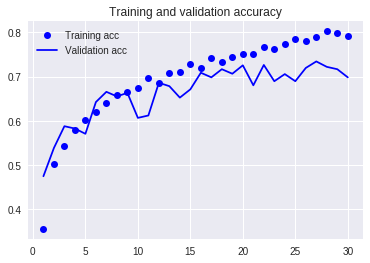

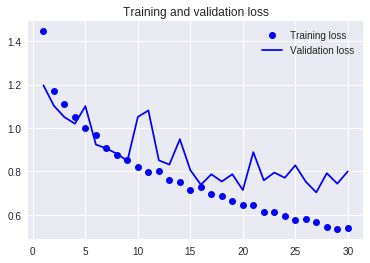

In [0]:
plot_curves()

### VGG16. Feature Extraction and Fine-Tuning

Now we try feature extraction with VGG16.  This is essentially taking off the top of the model and replacing it with our own layers which are randomly initialized and trained. We have to freeze the other layers to keep the weights. Otherwise, the weights would be destroyed. These models are pre-trained on ImageNet. The reason this works so well is that the features learned at the earlier layers in the convnet are more general (like horizontal or vertical lines) and become more specific (like faces or whole flowers in our example) as we go further into the network. Most of the earlier features are effective with other datasets. It is more effective when the data is similar to the data the network was originally trained on. ImageNet does have flower data so this should work reasonably well.












![vgg net](https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

Source: https://www.researchgate.net/figure/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only_fig3_322512435

In [0]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 7s 0us/step


In [0]:
vgg16_model

In [0]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
type(vgg16_model)

keras.engine.training.Model

In [0]:
# Create a new model without the last layer and freeze the other layers
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    layer.trainable = False
    

In [0]:
# add the new classifier
model.add(Dense(5, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

#### Training the Feature Extractor (1 - 10 epochs)

In [0]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

keras.callbacks.CSVLogger

Callbacks in Keras can be used to control the training process a bit more. Here we are reducing the learning rate if the validation loss does not drop after 10 epochs (`patience =10`). We also stop early more cleanly than cancelling the running cell after one epoch (`patience = 1`). We checkpoint (save) the model for the best validation loss. Adding the parameter `verbose=1` will log when the functions are being called.


In [0]:
# Run #1 without unfreezing

callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
    ),
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=10, 
                    verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 60s - loss: 1.3358 - acc: 0.4917 - val_loss: 0.9045 - val_acc: 0.6680
Epoch 2/10
 - 51s - loss: 0.7880 - acc: 0.7121 - val_loss: 0.7525 - val_acc: 0.7336
Epoch 3/10
 - 50s - loss: 0.6855 - acc: 0.7553 - val_loss: 0.6934 - val_acc: 0.7410
Epoch 4/10
 - 50s - loss: 0.6171 - acc: 0.7719 - val_loss: 0.6327 - val_acc: 0.7824
Epoch 5/10
 - 50s - loss: 0.5498 - acc: 0.7947 - val_loss: 0.6122 - val_acc: 0.7836
Epoch 6/10
 - 50s - loss: 0.5298 - acc: 0.8066 - val_loss: 0.5968 - val_acc: 0.7864
Epoch 7/10
 - 50s - loss: 0.4962 - acc: 0.8144 - val_loss: 0.5742 - val_acc: 0.7934
Epoch 8/10
 - 50s - loss: 0.4809 - acc: 0.8194 - val_loss: 0.5493 - val_acc: 0.7976
Epoch 9/10
 - 50s - loss: 0.4498 - acc: 0.8352 - val_loss: 0.5727 - val_acc: 0.7928
Epoch 10/10
 - 50s - loss: 0.4367 - acc: 0.8329 - val_loss: 0.5685 - val_acc: 0.7967


#### Training the Feature Extractor (2 - 30 epochs)

In [0]:
# Run #2 with freezing and 30 epochs
 

callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='feature-extraction.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=30, 
                    verbose = 2)

Epoch 1/30
 - 58s - loss: 1.5338 - acc: 0.3304 - val_loss: 1.4336 - val_acc: 0.3836
Epoch 2/30
 - 51s - loss: 1.3388 - acc: 0.4891 - val_loss: 1.2721 - val_acc: 0.5240
Epoch 3/30
 - 51s - loss: 1.2180 - acc: 0.5797 - val_loss: 1.1543 - val_acc: 0.6148
Epoch 4/30
 - 51s - loss: 1.1462 - acc: 0.5982 - val_loss: 1.0830 - val_acc: 0.6408
Epoch 5/30
 - 51s - loss: 1.0864 - acc: 0.6218 - val_loss: 1.0478 - val_acc: 0.6516
Epoch 6/30
 - 52s - loss: 1.0582 - acc: 0.6237 - val_loss: 0.9933 - val_acc: 0.6448
Epoch 7/30
 - 52s - loss: 1.0019 - acc: 0.6646 - val_loss: 0.9514 - val_acc: 0.7064
Epoch 8/30
 - 51s - loss: 0.9670 - acc: 0.6696 - val_loss: 0.9198 - val_acc: 0.6918
Epoch 9/30
 - 51s - loss: 0.9574 - acc: 0.6716 - val_loss: 0.9066 - val_acc: 0.6928
Epoch 10/30
 - 52s - loss: 0.9284 - acc: 0.6850 - val_loss: 0.8704 - val_acc: 0.7230
Epoch 11/30
 - 52s - loss: 0.9115 - acc: 0.6857 - val_loss: 0.8673 - val_acc: 0.7128
Epoch 12/30
 - 52s - loss: 0.8911 - acc: 0.6990 - val_loss: 0.8322 - val_a

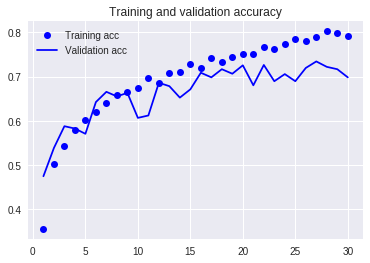

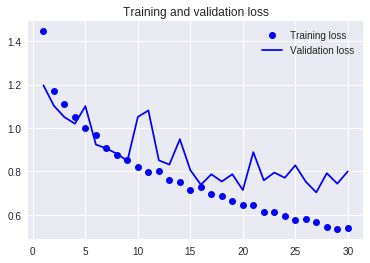

In [0]:
plot_curves()

#### Feature extraction with a new flatten layer and 2 dense layers at the end (IE a new top).

We get slightly better performance here with a max validation loss of 0.83 from 0.79 in the previous 2 models. There are more layers here to adjust.

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [0]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='feature-extraction-rmsprop-replaced-top.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=30, 
                    verbose = 2)

Epoch 1/30
 - 58s - loss: 1.1844 - acc: 0.5527 - val_loss: 0.9443 - val_acc: 0.6768
Epoch 2/30
 - 51s - loss: 0.8378 - acc: 0.7078 - val_loss: 0.7282 - val_acc: 0.7434
Epoch 3/30
 - 51s - loss: 0.7084 - acc: 0.7588 - val_loss: 0.6588 - val_acc: 0.7680
Epoch 4/30
 - 50s - loss: 0.6533 - acc: 0.7708 - val_loss: 0.6773 - val_acc: 0.7488
Epoch 5/30
 - 50s - loss: 0.5834 - acc: 0.7989 - val_loss: 0.6263 - val_acc: 0.7811
Epoch 6/30
 - 52s - loss: 0.5627 - acc: 0.8081 - val_loss: 0.5794 - val_acc: 0.7880
Epoch 7/30
 - 54s - loss: 0.5068 - acc: 0.8298 - val_loss: 0.5569 - val_acc: 0.8148
Epoch 8/30
 - 54s - loss: 0.4862 - acc: 0.8375 - val_loss: 0.5623 - val_acc: 0.8008
Epoch 9/30
 - 50s - loss: 0.4665 - acc: 0.8352 - val_loss: 0.5493 - val_acc: 0.8098
Epoch 10/30
 - 50s - loss: 0.4342 - acc: 0.8510 - val_loss: 0.5321 - val_acc: 0.8200
Epoch 11/30
 - 50s - loss: 0.4280 - acc: 0.8557 - val_loss: 0.5364 - val_acc: 0.8088
Epoch 12/30
 - 50s - loss: 0.4050 - acc: 0.8699 - val_loss: 0.4988 - val_a

In [0]:
plot_curves()

We continue training from the previous model with lower patience for `ReduceLROnPlateau`. This makes no significant difference.

In [0]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='feature-extraction-rmsprop-replaced-top-lr-lower.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=30, 
                    verbose = 2)

Epoch 1/30
 - 57s - loss: 0.2539 - acc: 0.9274 - val_loss: 0.4893 - val_acc: 0.8248

Epoch 00001: val_loss improved from inf to 0.48926, saving model to feature-extraction-rmsprop-replaced-top-lr-lower.h5
Epoch 2/30
 - 55s - loss: 0.2514 - acc: 0.9251 - val_loss: 0.4930 - val_acc: 0.8287

Epoch 00002: val_loss did not improve from 0.48926
Epoch 3/30
 - 56s - loss: 0.2496 - acc: 0.9301 - val_loss: 0.5027 - val_acc: 0.8240

Epoch 00003: val_loss did not improve from 0.48926
Epoch 4/30
 - 53s - loss: 0.2564 - acc: 0.9286 - val_loss: 0.4834 - val_acc: 0.8168

Epoch 00004: val_loss improved from 0.48926 to 0.48342, saving model to feature-extraction-rmsprop-replaced-top-lr-lower.h5
Epoch 5/30
 - 53s - loss: 0.2682 - acc: 0.9186 - val_loss: 0.4908 - val_acc: 0.8270

Epoch 00005: val_loss did not improve from 0.48342
Epoch 6/30
 - 53s - loss: 0.2481 - acc: 0.9344 - val_loss: 0.4870 - val_acc: 0.8248

Epoch 00006: val_loss did not improve from 0.48342
Epoch 7/30
 - 53s - loss: 0.2601 - acc: 0.

In [0]:
plot_curves()

#### Fine -Tuning 

We continue training the same model as above. We unfreeze the weights in the last block and reduce the learning rate so the pretrained weights are not destroyed. The validation accuracy increases slightly to 0.8608.

In [0]:
# modify the layers

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
len(model.trainable_weights)

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='fine-tuning.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=30, 
                    verbose = 2)

Epoch 1/30
 - 57s - loss: 0.2325 - acc: 0.9251 - val_loss: 0.5175 - val_acc: 0.8176

Epoch 00001: val_loss improved from inf to 0.51755, saving model to fine-tuning.h5
Epoch 2/30
 - 51s - loss: 0.2212 - acc: 0.9240 - val_loss: 0.5067 - val_acc: 0.8254

Epoch 00002: val_loss improved from 0.51755 to 0.50674, saving model to fine-tuning.h5
Epoch 3/30
 - 51s - loss: 0.1784 - acc: 0.9382 - val_loss: 0.5143 - val_acc: 0.8328

Epoch 00003: val_loss did not improve from 0.50674
Epoch 4/30
 - 51s - loss: 0.1643 - acc: 0.9467 - val_loss: 0.5051 - val_acc: 0.8448

Epoch 00004: val_loss improved from 0.50674 to 0.50515, saving model to fine-tuning.h5
Epoch 5/30
 - 50s - loss: 0.1304 - acc: 0.9583 - val_loss: 0.4602 - val_acc: 0.8385

Epoch 00005: val_loss improved from 0.50515 to 0.46024, saving model to fine-tuning.h5
Epoch 6/30
 - 51s - loss: 0.1198 - acc: 0.9637 - val_loss: 0.4963 - val_acc: 0.8336

Epoch 00006: val_loss did not improve from 0.46024
Epoch 7/30
 - 51s - loss: 0.1067 - acc: 0.96

In [0]:
plot_curves()

### DenseNet161. Feature Extraction and Fine-Tuning

#### Feature Extraction and Fine-Tuning with DenseNet161
Let's try another model. With feature extraction we don't get much better performance.


In [0]:
from keras.applications import DenseNet169

conv_base = DenseNet169(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

51879936/51877672 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_7 (Flatten)          (None, 81536)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               20873472  
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 33,517,637
Trainable params: 33,359,237
Non-trainable params: 158,400
_________________________________________________________________


In [0]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 510
This is the number of trainable weights after freezing the conv base: 4


In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='feature-extraction-densenet.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose = 1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=50, 
                    verbose = 2)

Epoch 1/50
 - 74s - loss: 0.7820 - acc: 0.7191 - val_loss: 0.8846 - val_acc: 0.6877
Epoch 2/50
 - 56s - loss: 0.3689 - acc: 0.8726 - val_loss: 0.7021 - val_acc: 0.7688
Epoch 3/50
 - 54s - loss: 0.2728 - acc: 0.9093 - val_loss: 0.6086 - val_acc: 0.8016
Epoch 4/50
 - 54s - loss: 0.2814 - acc: 0.8935 - val_loss: 0.5287 - val_acc: 0.8240
Epoch 5/50
 - 56s - loss: 0.1849 - acc: 0.9336 - val_loss: 0.5990 - val_acc: 0.8254
Epoch 6/50
 - 57s - loss: 0.1831 - acc: 0.9378 - val_loss: 0.6758 - val_acc: 0.8016
Epoch 7/50
 - 57s - loss: 0.1468 - acc: 0.9510 - val_loss: 0.7020 - val_acc: 0.7992
Epoch 8/50
 - 57s - loss: 0.1565 - acc: 0.9456 - val_loss: 0.7342 - val_acc: 0.7992
Epoch 9/50
 - 57s - loss: 0.1028 - acc: 0.9676 - val_loss: 0.7556 - val_acc: 0.8016
Epoch 10/50
 - 57s - loss: 0.1167 - acc: 0.9583 - val_loss: 0.7570 - val_acc: 0.7992
Epoch 11/50
 - 58s - loss: 0.1151 - acc: 0.9576 - val_loss: 0.8392 - val_acc: 0.7864

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.99999994947575

In [0]:
plot_curves()

#### Fine-Tuning

We reach max performance here with a validation accuracy of 0.9090.

In [0]:
len(model.trainable_weights)

4

In [0]:
# Restore the model weights
# modify the layers

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name.startswith( 'conv5' ):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
len(model.trainable_weights)

198

In [0]:
model.compile(optimizer=Adam(lr=1e-5, decay = 1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
%%time


callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='fine-tuning-densenet.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=30, 
                    verbose = 2)

Epoch 1/30
 - 90s - loss: 0.1941 - acc: 0.9332 - val_loss: 0.3814 - val_acc: 0.8832

Epoch 00001: val_loss improved from inf to 0.38136, saving model to fine-tuning-densenet.h5
Epoch 2/30
 - 60s - loss: 0.1524 - acc: 0.9429 - val_loss: 0.3611 - val_acc: 0.8885

Epoch 00002: val_loss improved from 0.38136 to 0.36105, saving model to fine-tuning-densenet.h5
Epoch 3/30
 - 60s - loss: 0.1081 - acc: 0.9618 - val_loss: 0.3851 - val_acc: 0.8896

Epoch 00003: val_loss did not improve from 0.36105
Epoch 4/30
 - 60s - loss: 0.1067 - acc: 0.9653 - val_loss: 0.4404 - val_acc: 0.8779

Epoch 00004: val_loss did not improve from 0.36105
Epoch 5/30
 - 61s - loss: 0.0906 - acc: 0.9691 - val_loss: 0.3900 - val_acc: 0.8976

Epoch 00005: val_loss did not improve from 0.36105
Epoch 6/30
 - 60s - loss: 0.0706 - acc: 0.9737 - val_loss: 0.3961 - val_acc: 0.8896

Epoch 00006: val_loss did not improve from 0.36105
Epoch 7/30
 - 60s - loss: 0.0597 - acc: 0.9792 - val_loss: 0.3740 - val_acc: 0.8992

Epoch 00007: 

In [0]:
plot_curves()

In [0]:
# adding in weight decay with Adam

epochs = 50
learning_rate = 1e-5
decay_rate = learning_rate / epochs

model.compile(optimizer=Adam(lr=learning_rate, decay = decay_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
# The error here and is intentional due to early stopping.

callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.01,
        patience=5,
        verbose = 1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        mode = 'min',
        restore_best_weights = True,
        verbose = 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='fine-tuning-densenet-learning-rate-scheduler.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model.fit_generator(train_batches, 
                    steps_per_epoch=81, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=40, 
                    epochs=epochs, 
                    verbose = 2)

Epoch 1/50
 - 82s - loss: 0.0602 - acc: 0.9768 - val_loss: 0.3376 - val_acc: 0.9090

Epoch 00001: val_loss improved from inf to 0.33760, saving model to fine-tuning-densenet-learning-rate-scheduler.h5
Epoch 2/50
 - 61s - loss: 0.0416 - acc: 0.9892 - val_loss: 0.3817 - val_acc: 0.9072

Epoch 00002: val_loss did not improve from 0.33760
Epoch 3/50
 - 60s - loss: 0.0383 - acc: 0.9865 - val_loss: 0.4089 - val_acc: 0.9008

Epoch 00003: val_loss did not improve from 0.33760
Epoch 4/50
 - 59s - loss: 0.0487 - acc: 0.9842 - val_loss: 0.3823 - val_acc: 0.9080

Epoch 00004: val_loss did not improve from 0.33760
Epoch 5/50


KeyboardInterrupt: ignored

#### Evalute the model on the Test Set
The best performing model is evaluated on the test set by reloading the saved version.

In [0]:
# restore the model and do some test set evaluation.
from keras.models import load_model
new_model = load_model('fine-tuning-densenet-learning-rate-scheduler.h5')

In [0]:
test_loss, test_acc = new_model.evaluate_generator(test_batches, steps=27)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.344316730827645
test acc: 0.9189814814814815


## Conclusion

We covered quite a lot of ground in this notebook. We imported, visualized and preprocessed data, built a few models and iteratively increased their sophistication and power via feature extraction and fine tuning pre-trained models. This is a general approach that can be applied to other computer vision datasets.

The best model was a fine-tuned DenseNet161 model with 91% test set accuracy and 90% validation set accuracy. Thus the null was rejected as the dataset performed worse than the precedent. 

## Further Work

- The model seems to be overfitting - try to fix this.
- Try different models like VGG19, Inception and ResNet.
- Try Fast.ai.
- Do more hyperparameter optimization. Try automated optimization.
- Try different methods for fine-tuning (eg. unfreeze different layers etc).
- Use a random seed to make the results reproducible.
- Train on a bigger dataset.
- Productionize with unit tests and a REST API etc.

## References

* Chollet, Francois. "Deep Learning with Python." (2017).

* Chollet, François. "Keras." (2015), https://keras.io.

* Deep Lizard. "Keras - Python Deep Learning Neural Network API." YouTube, Mar. 2019, https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL.

* Deng, Jia, et al. "Imagenet: A large-scale hierarchical image database." (2009): 248-255.

* Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. " O'Reilly Media, Inc.", 2017.

* Ng, Andrew. "Convolutional Neural Networks." Coursera, Mar. 2019, https://www.coursera.org/learn/convolutional-neural-networks/home/welcome.

* Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).









